In [20]:
import os
import av
import cv2
import numpy as np
import pandas as pd
import subprocess
from PIL import Image
import moviepy.editor as mp

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm
from IPython.display import Video
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [21]:
pio.renderers.default = 'notebook' # or 'notebook' or 'colab' or 'jupyterlab'

In [3]:
def generate_video(image_folder='.', fps=1):
    output_filename = os.path.join(image_folder, 'video.mp4')

    image_paths = sorted([img for img in os.listdir(image_folder) 
                          if img.endswith(".jpg") or
                             img.endswith(".jpeg") or
                             img.endswith(".png")],
                         key=lambda x: int(x.split('.')[0]))

    container = av.open(output_filename, "w")
    stream = container.add_stream("h264", fps)
    # Запись изображений в видео
    for image_path in image_paths:
        img = cv2.imread(os.path.join(image_folder, image_path))
        frame = av.VideoFrame.from_ndarray(img, format="rgb24")
        packet = stream.encode(frame)
        container.mux(packet)
    # Завершение записи видео
    packet = stream.encode(None)  # Посылаем None, чтобы завершить видеопоток
    container.mux(packet)
    # Закрытие видеопотока
    container.close()

    print(f"Видео сгенерировано: {output_filename}")

Видео сгенерировано: data/out1/video.mp4


In [ ]:
# Вызов функции генерации видео
generate_video(image_folder='data/out1')

In [68]:
def trim_video(input_file, output_file, start_time, end_time):
    # Загрузка видеофайла
    video_clip = mp.VideoFileClip(input_file)

    # Обрезка видео
    trimmed_clip = video_clip.subclip(start_time, end_time)

    # Сохранение обрезанного видео в новый файл
    trimmed_clip.write_videofile(output_file)

    # Освобождение ресурсов
    video_clip.close()
    trimmed_clip.close()

In [69]:
trim_video(input_file="data/D03_20230523134844.mp4",
           output_file="data/video_100_460.mp4",
           start_time=100,
           end_time=460)

Moviepy - Building video data/video_100_460.mp4.
Moviepy - Writing video data/video_100_460.mp4



Moviepy - Done !
Moviepy - video ready data/video_100_460.mp4


In [76]:
# https://github.com/analyticdan/motion-heatmap

def decay(accumulator, decay_const):
    return accumulator / decay_const

def rejuvenate(fgmask, accumulator, rejuvenate_const):
    fgmask = np.where(fgmask > 0, 1, 0)
    fgmask = np.stack((fgmask,) * 3, axis=-1)
    return np.maximum(accumulator, fgmask * rejuvenate_const)

def process_video(input_file='input_video.mp4', output_file='out.mp4', output=False, decay_rate=1.01):
    video = cv2.VideoCapture(input_file)
    if not video.isOpened():
        print("Ошибка при открытии видеофайла.")
        return
    
    frame_shape = (int(video.get(4)), int(video.get(3)), 3)
    decay_const = np.full(frame_shape, [decay_rate, 1, 1])
    rejuvenate_const = np.full(frame_shape, [179, 225, 225])
    accumulator = np.full(frame_shape, [0, 225, 225])
    
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    progress_bar = tqdm(total=total_frames, desc='Processing Frames', unit='frame')
    
    bg_subtractor = cv2.bgsegm.createBackgroundSubtractorMOG()
    
    frames = []
    
    while video.isOpened():
        try:
            ok, frame = video.read()
            if not ok:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            fgmask = bg_subtractor.apply(gray)
            accumulator = decay(accumulator, decay_const)
            accumulator = rejuvenate(fgmask, accumulator, rejuvenate_const)
            frame = cv2.cvtColor(accumulator.astype(np.uint8), cv2.COLOR_HSV2BGR)
            frames.append(frame)
            progress_bar.update(1)
        except KeyboardInterrupt:
            break
    progress_bar.close()
    if output:
        command = [
            'ffmpeg',
            '-y',  # Overwrite output file if it exists
            '-f', 'rawvideo',
            '-vcodec', 'rawvideo',
            '-s', f"{frame_shape[1]}x{frame_shape[0]}",  # size of one frame
            '-pix_fmt', 'bgr24',
            '-r', str(int(video.get(5))),  # frame rate of the input video
            '-i', '-',  # input comes from a pipe
            '-c:v', 'libx264',
            '-preset', 'ultrafast',
            '-crf', '25',  # constant rate factor
            output_file
        ]
        
        try:
            process = subprocess.Popen(command, stdin=subprocess.PIPE)
            for frame in frames:
                process.stdin.write(frame.tobytes())
            process.stdin.close()
            process.wait()
        except Exception as e:
            print("Ошибка при записи видео:", e)
            return
    
    video.release()
    return frames


In [77]:
images = process_video(input_file='data/video_100_460.mp4', output_file='data/video_100_460_motions.mp4', output=True, decay_rate=1.01)

Processing Frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9000/9000 [33:11<00:00,  4.52frame/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-l

In [200]:
Video("data/video_100_460.mp4", width=800, height=450)

In [79]:
Video("data/video_100_460_motions.mp4", width=800, height=450)

In [3]:
def hue_histogram(image, bins=16):
    # Преобразование изображения в HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Разбиение диапазона оттенков 
    hue_range = np.linspace(0, 179, bins+1)  # H значения в OpenCV варьируются от 0 до 179

    # Вычисление гистограммы
    histogram = np.zeros(bins)

    for i in range(bins):
        lower_bound = np.array([hue_range[i], 50, 50])  # Нижний предел интервала (H минимум, S и V значения)
        upper_bound = np.array([hue_range[i+1], 255, 255])  # Верхний предел интервала (H максимум, S и V значения)
        mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
        histogram[i] = cv2.countNonZero(mask)
    return histogram


def show_histogram(histogram, bins=16): 
    # Построение гистограммы
    plt.bar(np.arange(bins), histogram)
    plt.xlabel('Interval')
    plt.ylabel('Pixel Count')
    plt.title('Histogram of Hue')
    plt.show()

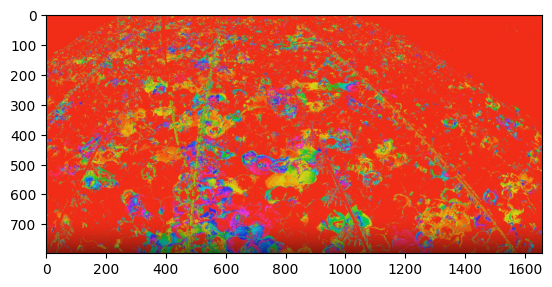

In [13]:
img = cv2.imread('data/screenshot.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

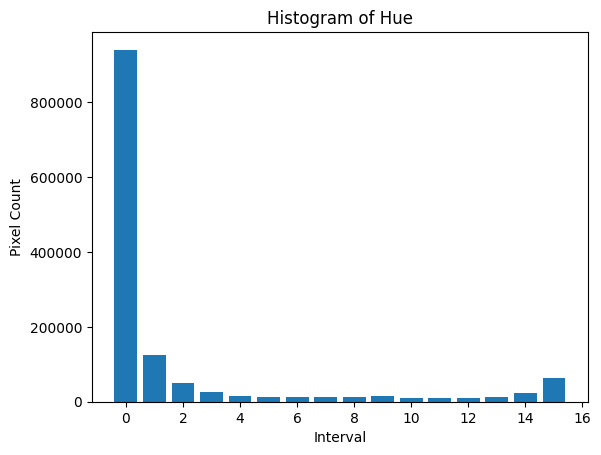

In [14]:
hist = hue_histogram(img, 16)
show_histogram(hist, 16)

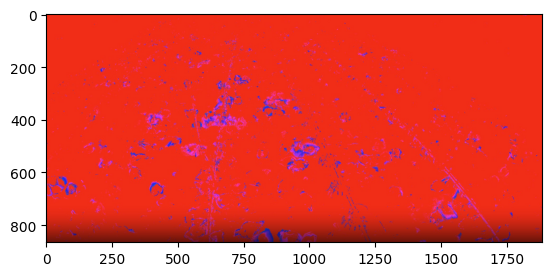

In [15]:
img = cv2.imread('data/screenshot_2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

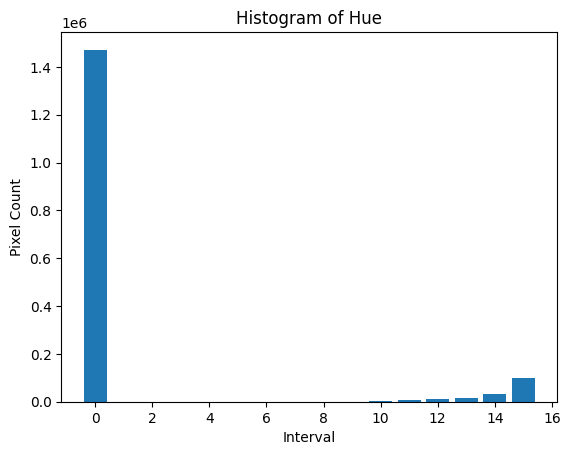

In [16]:
hist = hue_histogram(img, 16)
show_histogram(hist, 16)

In [24]:
# Путь к вашему видеофайлу
video_path = "data/video_100_460_motions.mp4"

# Период, с которым вы хотите применять функцию vectorize() к кадрам видео (в секундах)
period = 5

# Массив для хранения векторов
vectors = []
# Массив для хранения соответствующих изображений
frames = []

bins = 32

# Открываем видеофайл
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Ошибка открытия видеофайла")
else:
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    period_frames = int(period * fps)
    
    current_frame = 0
    
    progress_bar = tqdm(total=frame_count, desc='Processing Frames', unit='frame')
    while True:
        # Чтение кадра
        ret, frame = cap.read()
        
        if not ret:
            break
        
        if current_frame % period_frames == 0:
            vector = hue_histogram(frame, bins)
            vectors.append(vector)
            frames.append(frame)
            
        progress_bar.update(1)
        current_frame += 1

    cap.release()
    progress_bar.close()

Processing Frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 9000/9000 [02:26<00:00, 61.51frame/s]


In [25]:
# Берем векторы, сделанные после адаптации алгоритма    
vectors = np.array(vectors[3:])

# Ваш массив векторов готов
print("Количество векторов:", len(vectors))

Количество векторов: 69


In [26]:
print("Пример вектора:", vectors[1])

Пример вектора: [1446977.   75902.   65891.   44303.   41044.   31068.   24324.   21576.
   19168.   21426.   18907.   14312.   16361.   12610.   11258.    9226.
   14002.   13825.   11297.   11443.    9793.   11228.   10473.    7809.
    9341.    8518.    9361.    9853.    8117.    9840.    7409.  147926.]


In [27]:
resolution = 1920*1080
norm_vectors = np.array(vectors / resolution)

In [28]:
print("Пример нормализованного вектора:", norm_vectors[1])

Пример нормализованного вектора: [0.69780912 0.03660397 0.03177614 0.02136526 0.0197936  0.01498264
 0.01173032 0.01040509 0.00924383 0.01033275 0.00911796 0.00690201
 0.00789014 0.00608121 0.00542921 0.00444927 0.00675251 0.00666715
 0.00544801 0.00551842 0.0047227  0.00541474 0.00505064 0.00376591
 0.00450473 0.00410783 0.00451437 0.00475164 0.00391445 0.00474537
 0.00357301 0.07133777]


In [29]:
# PCA для снижения размерности до 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(norm_vectors)

In [31]:
# Получение 2D координат для каждого вектора
x = pca_result[:, 0]
y = pca_result[:, 1]

# Создание графика
fig = go.Figure()

# Добавление точек на график
fig.add_trace(go.Scatter(x=x, y=y, mode='markers', marker=dict(size=10), text=[str(i) for i in range(len(vectors))]))

# Настройка макета и осей
fig.update_layout(
    title="PCA Projection with Annotations",
    xaxis=dict(title="Principal Component 1"),
    yaxis=dict(title="Principal Component 2"),
    showlegend=False
)

# Отображение графика
fig.show()

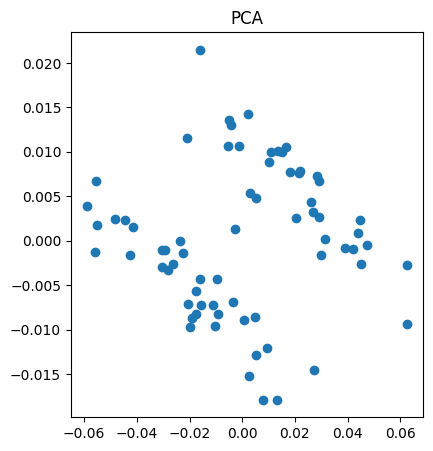

In [49]:
# Визуализация результата PCA
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA')
plt.show()

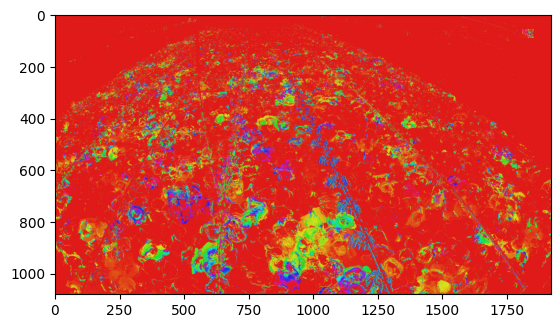

In [43]:
# "Правая кучка" 
plt.imshow(cv2.cvtColor(frames[7], cv2.COLOR_BGR2RGB))
plt.show()

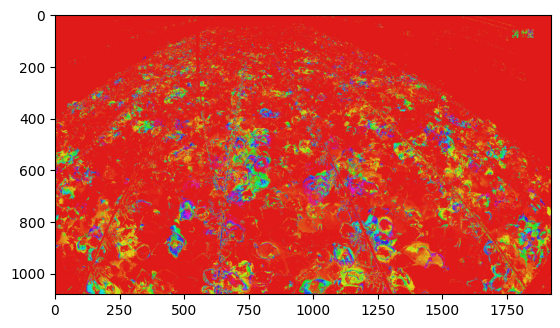

In [44]:
# "Левая кучка" 
plt.imshow(cv2.cvtColor(frames[32], cv2.COLOR_BGR2RGB))
plt.show()

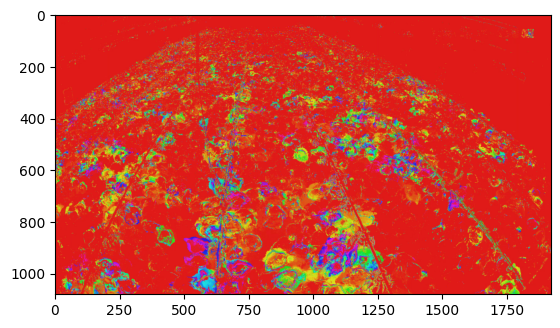

In [45]:
# "Правая кучка" 
plt.imshow(cv2.cvtColor(frames[47], cv2.COLOR_BGR2RGB))
plt.show()

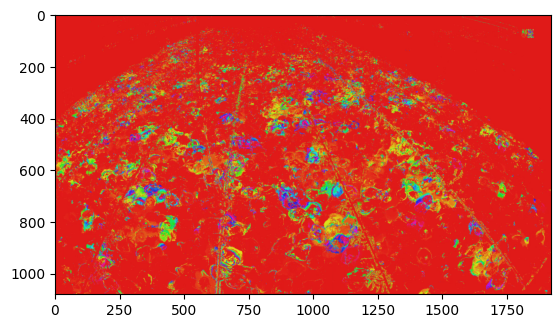

In [50]:
# "Левая кучка" 
plt.imshow(cv2.cvtColor(frames[54], cv2.COLOR_BGR2RGB))
plt.show()

In [195]:
# t-SNE для снижения размерности до 2 с установкой perplexity
tsne = TSNE(n_components=2, perplexity=5) 
tsne_result = tsne.fit_transform(norm_vectors)

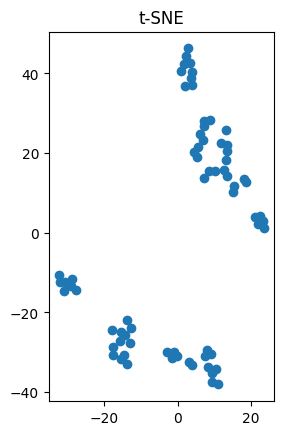

In [196]:
# Визуализация результата t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE')
plt.show()

In [203]:
df = pd.read_excel('data/out1/D03_20230523134844.mp4.xlsx')
df = df.iloc[1:9]
df

,Unnamed: 0,minNegPressure,meanNegPressure,maxNegPressure,minHumidity,meanHumidity,maxHumidity,minT1,meanT1,maxT1,...,minT3,meanT3,maxT3,minT4,meanT4,maxT4,minT5,meanT5,maxT5,dt
1,1,-0.1,-0.1,-0.1,51.421667,52.135167,52.635167,33.500000,34.151333,34.775667,...,32.524333,33.064833,33.591833,31.800,32.5405,32.981000,25.551333,26.4135,27.202667,2023-05-23 13:49:44
2,2,-0.1,-0.1,-0.1,51.521667,52.205167,52.705167,33.500000,34.111333,34.755667,...,32.544333,32.994833,33.461833,31.800,32.4505,32.801000,25.511333,26.3835,27.122667,2023-05-23 13:50:44
3,3,-0.1,-0.1,-0.1,51.621667,52.275167,52.775167,33.500000,34.071333,34.735667,...,32.564333,32.924833,33.331833,31.800,32.3605,32.621000,25.471333,26.3535,27.042667,2023-05-23 13:51:44
4,4,-0.1,-0.1,-0.1,51.721667,52.345167,52.845167,33.500000,34.031333,34.715667,...,32.584333,32.854833,33.201833,31.800,32.2705,32.441000,25.431333,26.3235,26.962667,2023-05-23 13:52:44
5,5,-0.1,-0.1,-0.1,50.604333,51.210833,52.102167,33.304333,34.106500,34.410833,...,33.378333,34.087000,34.497833,32.974,33.6870,34.197833,25.800000,26.3065,26.721667,2023-05-23 13:53:44
6,6,-0.1,-0.1,-0.1,50.624333,51.260833,52.112167,33.324333,34.136500,34.460833,...,33.278333,34.027000,34.487833,32.854,33.6270,34.187833,25.800000,26.3365,26.821667,2023-05-23 13:54:44
7,7,-0.1,-0.1,-0.1,50.644333,51.310833,52.122167,33.344333,34.166500,34.510833,...,33.178333,33.967000,34.477833,32.734,33.5670,34.177833,25.800000,26.3665,26.921667,2023-05-23 13:55:44
8,8,-0.1,-0.1,-0.1,50.664333,51.360833,52.132167,33.364333,34.196500,34.560833,...,33.078333,33.907000,34.467833,32.614,33.5070,34.167833,25.800000,26.3965,27.021667,2023-05-23 13:56:44


In [198]:
duration = len(df.index)
print(duration)

68


In [5]:
print(df.loc[:, ['minNegPressure', 'meanNegPressure', 'maxNegPressure']])

    minNegPressure  meanNegPressure  maxNegPressure
0             -0.1             -0.1            -0.1
1             -0.1             -0.1            -0.1
2             -0.1             -0.1            -0.1
3             -0.1             -0.1            -0.1
4             -0.1             -0.1            -0.1
..             ...              ...             ...
63            -0.1             -0.1            -0.1
64            -0.1             -0.1            -0.1
65            -0.1             -0.1            -0.1
66            -0.1             -0.1            -0.1
67            -0.1             -0.1            -0.1

[68 rows x 3 columns]


In [40]:
def plot_series(label, x_axis, series_list):
    """
    Построение графика для списка pandas.Series

    Параметры:
    - x_axis: числовая ось, которая будет использоваться как ось X
    - series_list: список pandas.Series для построения графика
    """
    names = []
    if isinstance(series_list, list):
        for series in series_list:
            plt.plot(x_axis, series.values)
            names.append(series.name)
    else:
        for column_name, values in series_list.items():
            plt.plot(x_axis, values)
            names.append(column_name)
    plt.xlabel('X')
    plt.ylabel('Values')
    plt.title(label)
    plt.legend(names)
    
    plt.show()

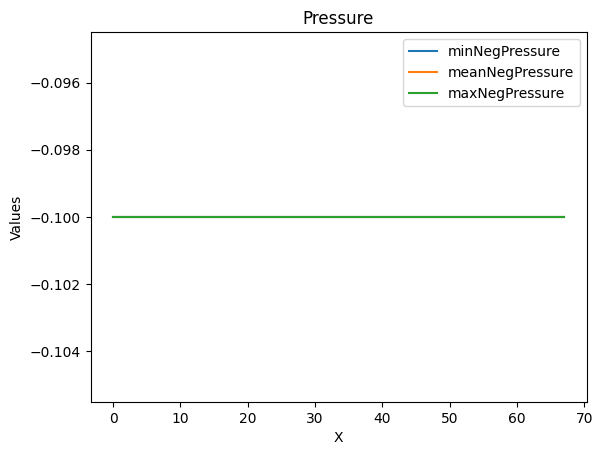

In [41]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('Pressure', x_axis, series_list=df.loc[:, ['minNegPressure', 'meanNegPressure', 'maxNegPressure']])

In [16]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('Humidity', x_axis, series_list=df.loc[:, ['minHumidity', 'meanHumidity', 'maxHumidity']])

NameError: name 'duration' is not defined

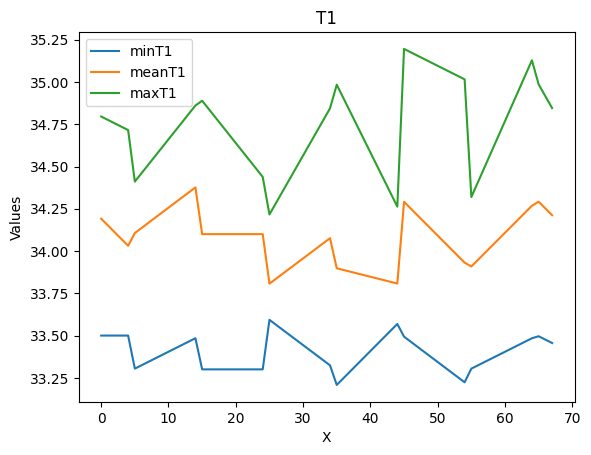

In [30]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T1', x_axis, series_list=df.loc[:, ['minT1', 'meanT1', 'maxT1']])

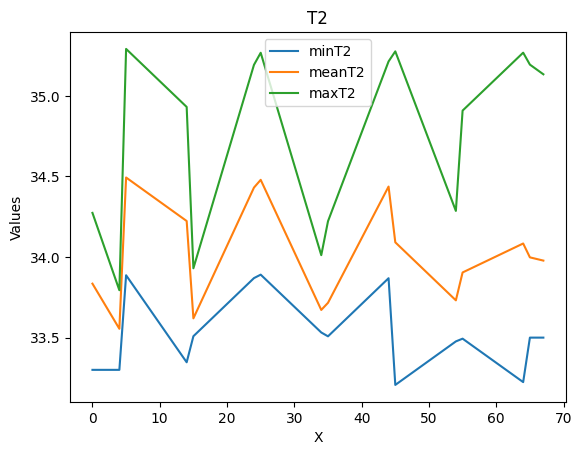

In [31]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T2', x_axis, series_list=df.loc[:, ['minT2', 'meanT2', 'maxT2']])

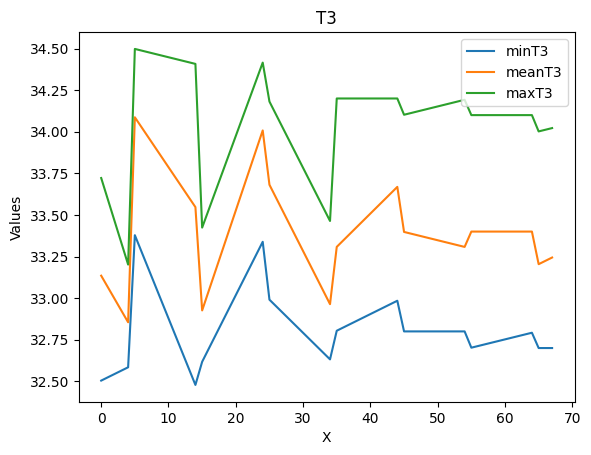

In [32]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T3', x_axis, series_list=df.loc[:, ['minT3', 'meanT3', 'maxT3']])

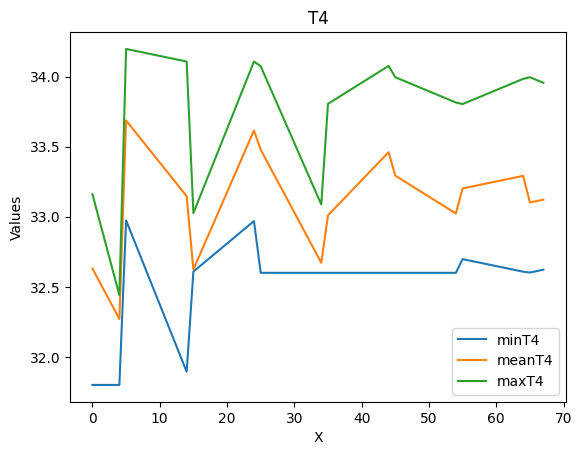

In [33]:
# Создаем набор данных
x_axis = np.arange(0, duration) 

# Вызываем функцию для построения графика
plot_series('T4', x_axis, series_list=df.loc[:, ['minT4', 'meanT4', 'maxT4']])

## Усредним значения с разных датчиков

In [35]:
def average_columns(df, columns, label=None):
    """
    Усредняет значения четырех колонок DataFrame.

    Параметры:
    - df: pandas.DataFrame
        Исходный DataFrame.
    - columns: list
        Список названий колонок, которые требуется усреднить.

    Возвращает:
    - pandas.Series
        Серия с усредненными значениями.
    """
    
    return pd.Series(df[columns].mean(axis=1), name=label)

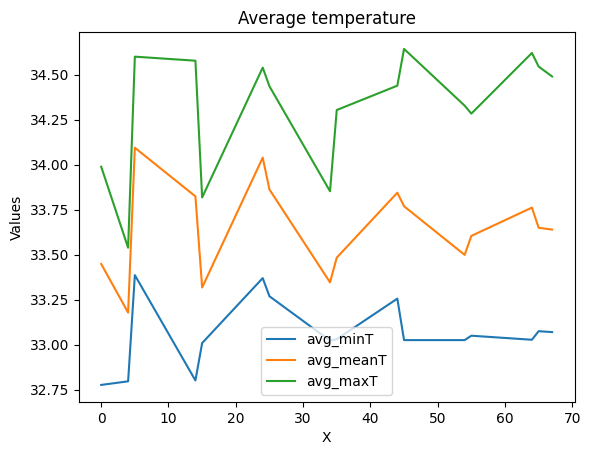

In [43]:
avg_min_temp = average_columns(df, ['minT1', 'minT2', 'minT3', 'minT4'], 'avg_minT')
avg_mean_temp = average_columns(df, ['meanT1', 'meanT2', 'meanT3', 'meanT4'], 'avg_meanT')
avg_max_temp = average_columns(df, ['maxT1', 'maxT2', 'maxT3', 'maxT4'], 'avg_maxT')
# Создаем набор данных
x_axis = np.arange(0, duration) 
# Вызываем функцию для построения графика
plot_series('Average temperature', x_axis, series_list=[avg_min_temp, avg_mean_temp, avg_max_temp])